In [1]:
import sys
import os
import shutil
import errno
from glob import glob
from decimal import Decimal
from pylab import *
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import glob
import re
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 8,6
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['font.size'] = 10
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

# Creating the Directory Structure

In [2]:
max_lattice_size = 6
'''Rectangular Lattice
for n in range(2,max_lattice_size+1):
    for m in range(2,max_lattice_size+1):
        for x in  range(2, m*n-1):
            if(m>=n): #preventing creation of both mxn and nxm
                dir = '../data/'+str(n)+'x'+str(m)+'/'+str(x)+'_occupants'
                if not os.path.exists(dir):
                    os.makedirs(dir)
'''
#Square Lattice
for n in range(2,max_lattice_size+1):
    for x in  range(2, n*n-1):
        dir = '../data/'+str(n)+'x'+str(n)+'/'+str(x)+'_occupants'
        if not os.path.exists(dir):
            os.makedirs(dir)            

# Constants

In [2]:
COLLAPSE_LIMIT_FRACTION = 0.001
PRE_CONVERGENCE_DATA_POINTS = 6
DISTANCE_LIMIT = 0.2

# Data gathering functions

In [3]:
def get_all_data():
    my_dir = '../data/2x2/2_occupants/'
    data_mcbb_whole, data_mcbf_whole, data_adia_whole = [[],[]],[[],[]],[[],[]]

    for filepath in glob.iglob(my_dir + '*.txt'):
        if 'MCBB' in filepath:
            data_mcbb_whole[0].append(filepath)
            data_mcbb_whole[1].append(get_data(filepath))
        elif 'MCBF' in filepath:
            data_mcbf_whole[0].append(filepath)
            data_mcbf_whole[1].append(get_data(filepath))
        elif 'ADIA' in filepath:
            data_adia_whole[0].append(filepath)
            data_adia_whole[1].append(get_data(filepath)) 

    return data_mcbb_whole, data_mcbf_whole, data_adia_whole



def get_params(filepath):
    names, values = [], []       
    file = open(filepath, "rt")
   
    for line in file:
        
        if "START_PARAMETERS" in line: continue
        if "END_PARAMETERS" in line: break
            
        line = line.rstrip("\n")
        line_split = line.rstrip("\n").split(' ')
        names.append(line_split[0].rstrip("=")) 
        values.append(line_split[-1])
        
    return [names, values]


def string_of_array_to_array_of_types(line, type):
    string_array = (line.split('=')[1]).split(' ')
    #while '[' in string_array: string_array.remove('[')
    #while ']' in string_array: string_array.remove(']')
    while ' ' in string_array: string_array.remove(' ')
    while '' in string_array: string_array.remove('')
    while ']' in string_array: string_array.remove(']')
    string_array[0] = string_array[0].split("[")[1]
    string_array[-1] = string_array[-1].split("]")[0]
    for x in range(len(string_array)):string_array[x] = string_array[x].rstrip(',')
    if(len(string_array)<= 1): return [0]
    return [type(i) for i in string_array]


def get_values(dictionary, name):
    try:
        names = dictionary[0]
        values = dictionary[1]
        index = names.index(name)
        return values[index]
    except:
        return 0

    
def reshape_list(old_list, sub_array_indices):
    new_list = []
    for x in range(len(sub_array_indices)-1):
        new_list.append(old_list[sub_array_indices[x] : sub_array_indices[x+1]])
    return new_list


def get_data(filepath): 
    parameters = get_params(filepath)
    names, values = [], []
    seeds, taus, ground_Es,initial_taus,initial_Es, total_steps = [], [], [], [], [], []
    j_protocols, k_protocols, b_protocols, jkb_vals  = [], [],[], []
    j_inits, k_inits, b_inits = [], [], []
    tau_arrays, best_E_arrays, total_steps_cummulative_sums = [],[],[]
    
    for line in open(filepath, "rt"):     
        line = line.rstrip("\n")
        if line.startswith('seed'): seeds.append(int(line.split(' ')[-1]))
        elif (line.startswith('tau') and ("array" not in line)): taus.append(float(line.split(' ')[-1])) 
        elif (line.startswith('total_steps') and ("sum" not in line)): total_steps.append(int(line.split(' ')[-1]))        
        elif line.startswith('ground_E'): ground_Es.append(float(line.split(' ')[-1]))     
        elif line.startswith('j_protocol'): j_protocols.append(string_of_array_to_array_of_types(line, float))
        elif line.startswith('k_protocol'): k_protocols.append(string_of_array_to_array_of_types(line, float))
        elif line.startswith('b_protocol'): b_protocols.append(string_of_array_to_array_of_types(line, float))
        elif line.startswith('j/k/b'): jkb_vals.append(string_of_array_to_array_of_types(line, int))
        elif line.startswith('tau_array'): tau_arrays.append(string_of_array_to_array_of_types(line, float)), initial_taus.append(tau_arrays[-1][0])
        elif line.startswith('best_E_array'): best_E_arrays.append(string_of_array_to_array_of_types(line, float)), initial_Es.append(best_E_arrays[-1][0])
        elif line.startswith('total_steps_cummulative_sum'): total_steps_cummulative_sums.append(string_of_array_to_array_of_types(line, int))
 
    number_of_bangs = get_values(parameters, "NUMBER_OF_BANGS")  
    total_steps_init = get_values(parameters, "TOTAL_STEPS_INIT_MC") 
    if(number_of_bangs): number_of_bangs = int(number_of_bangs)
    if(total_steps_init): total_steps_init = int(total_steps_init)

    for x in range(len(seeds)): 
        sub_array_indices = []
        if(number_of_bangs):
            for y in range(len(tau_arrays[x])+1): sub_array_indices.append(y*2*number_of_bangs)
        if(total_steps_init):
            sub_array_indices = total_steps_cummulative_sums[x]
            sub_array_indices.insert(0,0)
            
        j_protocols[x] = reshape_list(j_protocols[x], sub_array_indices)
        k_protocols[x] = reshape_list(k_protocols[x], sub_array_indices)
        b_protocols[x] = reshape_list(b_protocols[x], sub_array_indices)

        j_inits.append(j_protocols[x][0])
        k_inits.append(k_protocols[x][0])
        b_inits.append(b_protocols[x][0])
        del j_protocols[x][0]
        del k_protocols[x][0]
        del b_protocols[x][0]
        del best_E_arrays[x][0]
        del tau_arrays[x][0]

            
    potential_names = ['parameters', 'seeds', 'taus', 'ground_Es','initial_taus','initial_Es', 'total_steps', 'j_protocols',
                       'k_protocols', 'b_protocols', 'jkb_vals', 'tau_arrays', 'best_E_arrays', 'total_steps_cummulative_sums',
                      'j_inits', 'k_inits', 'b_inits' ]
    potential_values = [parameters, seeds, taus, ground_Es,initial_taus,initial_Es,  total_steps, j_protocols, 
                        k_protocols, b_protocols, jkb_vals, tau_arrays, best_E_arrays, total_steps_cummulative_sums,
                       j_inits, k_inits, b_inits]

    for x in range(len(potential_values)):
        if (len(potential_values[x]) == 0): continue
        names.append(potential_names[x])
        values.append(potential_values[x])

    return [names, values]

# Analysis Functions

In [4]:
def analyze_all_data(data_mcbb_whole, data_mcbf_whole, data_adia_whole):
    reduce_time_array(data_mcbb_whole)
    extrapolate_pre_convergence_time(data_mcbb_whole)
    calc_time_of_jumps_vs_tau(data_mcbb_whole)  
    calc_num_jumps(data_mcbb_whole)

    calc_num_jumps_vs_tau(data_mcbb_whole)
    calc_num_jumps_vs_system_size(data_mcbb_whole)
    calc_time_of_jumps_vs_system_size(data_mcbb_whole)
    calc_tau_vs_system_size(data_mcbb_whole)
    #find_num_jumps(data)



def extrapolate_pre_convergence_time(data_mcbb_whole):
    for data in data_mcbb_whole[1]:
        seeds = get_values(data, "seeds")
        ground_Es = get_values(data, "ground_Es")
        intial_Es = get_values(data, "initial_Es")
        tau_arrays = get_values(data, "tau_arrays")
        best_E_arrays = get_values(data, "best_E_arrays")
        j_protocols_reduced = get_values(data, "j_protocols_reduced")
        k_protocols_reduced = get_values(data, "k_protocols_reduced")
        b_protocols_reduced = get_values(data, "b_protocols_reduced")

        j_protocols_extrapolated, k_protocols_extrapolated, b_protocols_extrapolated, taus_extrapolated = [], [], [], []

        for x in range(len(seeds)):
                        
            if(len(best_E_arrays[x]) == 0):
                j_protocols_extrapolated.append([])
                k_protocols_extrapolated.append([])
                b_protocols_extrapolated.append([])   
                taus_extrapolated.append([])
                continue

            ground_E, initial_E, taus, best_Es = ground_Es[x], intial_Es[x], np.array(tau_arrays[x]), np.array(best_E_arrays[x])
            js_extrapolated_per_seed, ks_extrapolated_per_seed, bs_extrapolated_per_seed = [], [], []
            j_index, k_index, b_index = [], [], []
            

            point_within_dist_lim = np.where((best_Es-ground_E)/(initial_E-ground_E) < DISTANCE_LIMIT)[0]   

            if (len(point_within_dist_lim) > 1):
                
                taus = taus[point_within_dist_lim]
                best_Es = best_Es[point_within_dist_lim]

                tau_line = np.poly1d(np.polyfit(best_Es, taus,1))
                extrapolated_tau= max(tau_line(ground_E), taus[-1])

                js_reduced_per_seed = list(np.array(j_protocols_reduced[x])[point_within_dist_lim])
                ks_reduced_per_seed = list(np.array(k_protocols_reduced[x])[point_within_dist_lim])
                bs_reduced_per_seed = list(np.array(b_protocols_reduced[x])[point_within_dist_lim])

                size_j, size_k, size_b = len(js_reduced_per_seed[-1]),len(ks_reduced_per_seed[-1]),len(bs_reduced_per_seed[-1])


                for y in range(len(point_within_dist_lim)):
                    if (len(js_reduced_per_seed[y]) == size_j):j_index.append(y)
                    if (len(ks_reduced_per_seed[y]) == size_k):k_index.append(y)
                    if (len(bs_reduced_per_seed[y]) == size_b):b_index.append(y)

                js_reduced_per_seed2, ks_reduced_per_seed2, bs_reduced_per_seed2, = [], [] ,[]
                for y in range(len(j_index)): js_reduced_per_seed2.append(js_reduced_per_seed[j_index[y]])
                for y in range(len(k_index)): ks_reduced_per_seed2.append(ks_reduced_per_seed[k_index[y]])
                for y in range(len(b_index)): bs_reduced_per_seed2.append(bs_reduced_per_seed[b_index[y]])

                js_reduced_per_seed = np.array([np.array(xi) for xi in js_reduced_per_seed2]).T
                ks_reduced_per_seed = np.array([np.array(xi) for xi in ks_reduced_per_seed2]).T
                bs_reduced_per_seed = np.array([np.array(xi) for xi in bs_reduced_per_seed2]).T

                if(len(j_index) > 2):
                    for y in range(len(js_reduced_per_seed)):
                        j_line = np.poly1d(np.polyfit(taus[j_index],js_reduced_per_seed[y], 1))
                        interpolated_j = j_line(extrapolated_tau)

                        if(interpolated_j <= 0):  js_extrapolated_per_seed.append(0)
                        elif(interpolated_j >= taus[-1]): js_extrapolated_per_seed.append(taus[-1])
                        elif((y > 0) and (interpolated_j < js_extrapolated_per_seed[-1])): js_extrapolated_per_seed.append(js_extrapolated_per_seed[-1])
                        else: js_extrapolated_per_seed.append(interpolated_j)

                else: js_extrapolated_per_seed.extend(j_protocols_reduced[x][-1])

                if(len(k_index) > 2):
                    for y in range(len(ks_reduced_per_seed)):
                        k_line = np.poly1d(np.polyfit(taus[k_index],ks_reduced_per_seed[y], 1))
                        interpolated_k = k_line(extrapolated_tau)

                        if(interpolated_k <= 0):  ks_extrapolated_per_seed.append(0)
                        elif(interpolated_k >= taus[-1]): ks_extrapolated_per_seed.append(taus[-1])
                        elif((y > 0) and (interpolated_k < ks_extrapolated_per_seed[-1])): ks_extrapolated_per_seed.append(ks_extrapolated_per_seed[-1])
                        else: ks_extrapolated_per_seed.append(interpolated_k)

                else: ks_extrapolated_per_seed.extend(k_protocols_reduced[x][-1])

                if(len(b_index) > 2):
                    for y in range(len(bs_reduced_per_seed)):
                        b_line = np.poly1d(np.polyfit(taus[b_index],bs_reduced_per_seed[y], 1))
                        interpolated_b = b_line(extrapolated_tau)

                        if(interpolated_b <= 0):  bs_extrapolated_per_seed.append(0)
                        elif(interpolated_b >= taus[-1]): bs_extrapolated_per_seed.append(taus[-1])
                        elif((y > 0) and (interpolated_b < bs_extrapolated_per_seed[-1])): bs_extrapolated_per_seed.append(bs_extrapolated_per_seed[-1])
                        else: bs_extrapolated_per_seed.append(interpolated_b)

                else: bs_extrapolated_per_seed.extend(b_protocols_reduced[x][-1])


            else:
                js_extrapolated_per_seed.extend(j_protocols_reduced[x][-1])
                ks_extrapolated_per_seed.extend(k_protocols_reduced[x][-1])
                bs_extrapolated_per_seed.extend(b_protocols_reduced[x][-1])

            j_protocols_extrapolated.append(js_extrapolated_per_seed)
            k_protocols_extrapolated.append(ks_extrapolated_per_seed)
            b_protocols_extrapolated.append(bs_extrapolated_per_seed)   
            taus_extrapolated.append(extrapolated_tau)

        data[0].append('j_protocols_extrapolated')
        data[1].append(j_protocols_extrapolated)
        data[0].append('k_protocols_extrapolated')
        data[1].append(k_protocols_extrapolated)
        data[0].append('b_protocols_extrapolated')
        data[1].append(b_protocols_extrapolated)
        data[0].append('taus_extrapolated')
        data[1].append(taus_extrapolated)
        
        
def reduce_time_array(data_mcbb_whole):
    
    for data_mcbb in data_mcbb_whole[1]:
        j_protocols, k_protocols, b_protocols = get_values(data_mcbb, "j_protocols"), get_values(data_mcbb, "k_protocols"), get_values(data_mcbb, "b_protocols")
        j_protocols_reduced, k_protocols_reduced, b_protocols_reduced = [], [], []

        old_lists = [j_protocols,k_protocols,b_protocols]
        new_lists = [j_protocols_reduced,k_protocols_reduced,b_protocols_reduced]
        new_list_names = ['j_protocols_reduced', 'k_protocols_reduced','b_protocols_reduced']    

        for x in range(len(old_lists)): #iterate over lists        
            reduced_times = []
            for y in range(len(old_lists[x])): #iterate over seed
                
        
                reduce_times_per_seed = []
                for z in range(len(old_lists[x][y])): #iterate over each protocls within the seed

                    old_protocol = (old_lists[x][y][z]).copy()

                    collapse_limit = (old_protocol[-1] - old_protocol[0])*COLLAPSE_LIMIT_FRACTION
                    index=0
                    max_loops = len(old_protocol)

                    while(index<max_loops-1):
                        if(abs(old_protocol[index]-old_protocol[index+1]) < collapse_limit):
                            del old_protocol[index+1]
                            del old_protocol[index]
                            max_loops -= 2
                        else: index += 1  

                    reduce_times_per_seed.append(old_protocol)
                reduced_times.append(reduce_times_per_seed)
            data_mcbb[1].append(reduced_times)
            data_mcbb[0].append(new_list_names[x])
        

def get_optimal_tau_seed_index(data):
    seeds = get_values(data, "seeds")
    taus = get_values(data, "taus")
    min_tau = min(taus)
    min_time_index = taus.index(min_tau)
    min_seed = seeds[min_time_index]
    return min_tau, min_seed, min_time_index


def compare_protocols(data):
    return 1
    
    
def calc_time_of_jumps_vs_tau(data_mcbb_whole):
    
    for data_per_file_mcbb in data_mcbb_whole[1]:
        
        j_jumps_vs_tau, k_jumps_vs_tau, b_jumps_vs_tau,  = [], [], []
        j_jumps_vs_tau_ext, k_jumps_vs_tau_ext, b_jumps_vs_tau_ext,  = [], [], []
        names = ['j_jumps_vs_tau', 'k_jumps_vs_tau', 'b_jumps_vs_tau', 'j_jumps_vs_tau_ext', 'k_jumps_vs_tau_ext', 'b_jumps_vs_tau_ext', ]
        arrays = [j_jumps_vs_tau, k_jumps_vs_tau, b_jumps_vs_tau,j_jumps_vs_tau_ext, k_jumps_vs_tau_ext, b_jumps_vs_tau_ext]                
        
        taus_extrapolated = get_values(data_per_file_mcbb, "taus_extrapolated")
        j_protocols_extrapolated = get_values(data_per_file_mcbb, "j_protocols_extrapolated")
        k_protocols_extrapolated = get_values(data_per_file_mcbb, "k_protocols_extrapolated")
        b_protocols_extrapolated = get_values(data_per_file_mcbb, "b_protocols_extrapolated")
        
        tau_arrays = get_values(data_per_file_mcbb, "tau_arrays")
        j_protocols_reduced = get_values(data_per_file_mcbb, "j_protocols_reduced")
        k_protocols_reduced = get_values(data_per_file_mcbb, "k_protocols_reduced")
        b_protocols_reduced = get_values(data_per_file_mcbb, "b_protocols_reduced")

        
        for seed in range(len(tau_arrays)):
            
            if(len(tau_arrays[seed]) >= 2):

                tau_array_per_seed = tau_arrays[seed]
                j_protocols_reduced_per_seed = j_protocols_reduced[seed]
                k_protocols_reduced_per_seed = k_protocols_reduced[seed]
                b_protocols_reduced_per_seed = b_protocols_reduced[seed]     
                tau_extrapolated = taus_extrapolated[seed]
                j_protocol_extrapolated_per_seed = j_protocols_extrapolated[seed]
                k_protocol_extrapolated_per_seed = k_protocols_extrapolated[seed]
                b_protocol_extrapolated_per_seed = b_protocols_extrapolated[seed]

                j_jumps_vs_tau_per_seed = []
                k_jumps_vs_tau_per_seed = []
                b_jumps_vs_tau_per_seed = []

                for x in range(len(tau_array_per_seed)):
                    tau = tau_array_per_seed[x]
                    j_jumps_vs_tau_per_seed.append(list(np.array(j_protocols_reduced_per_seed[x])/tau))
                    k_jumps_vs_tau_per_seed.append(list(np.array(k_protocols_reduced_per_seed[x])/tau))
                    b_jumps_vs_tau_per_seed.append(list(np.array(b_protocols_reduced_per_seed[x])/tau))

                
                j_jumps_vs_tau.append(j_jumps_vs_tau_per_seed)
                k_jumps_vs_tau.append(k_jumps_vs_tau_per_seed)
                b_jumps_vs_tau.append(b_jumps_vs_tau_per_seed)
        
                j_jumps_vs_tau_ext.append(list(np.array(j_protocol_extrapolated_per_seed)/tau_extrapolated))
                k_jumps_vs_tau_ext.append(list(np.array(k_protocol_extrapolated_per_seed)/tau_extrapolated))
                b_jumps_vs_tau_ext.append(list(np.array(b_protocol_extrapolated_per_seed)/tau_extrapolated))

            else:
                j_jumps_vs_tau.append([])
                k_jumps_vs_tau.append([])
                b_jumps_vs_tau.append([])
                j_jumps_vs_tau_ext.append([])
                k_jumps_vs_tau_ext.append([])
                b_jumps_vs_tau_ext.append([])
      

        for x in range(len(names)):
            data_per_file_mcbb[0].append(names[x])
            data_per_file_mcbb[1].append(arrays[x])


def calc_num_jumps(data_mcbb_whole):
    
    for data_per_file_mcbb in data_mcbb_whole[1]:
        
        j_jumps, k_jumps, b_jumps = [], [], []
        j_extrapolated_jumps, k_extrapolated_jumps, b_extrapolated_jumps = [], [], []
        names = ['j_jumps', 'k_jumps', 'b_jumps', 'j_extrapolated_jumps', 'k_extrapolated_jumps', 'b_extrapolated_jumps', ]
        arrays = [j_jumps, k_jumps, b_jumps,j_extrapolated_jumps, k_extrapolated_jumps, b_extrapolated_jumps]
        
        taus_extrapolated = get_values(data_per_file_mcbb, "taus_extrapolated")
        j_protocols_extrapolated = get_values(data_per_file_mcbb, "j_protocols_extrapolated")
        k_protocols_extrapolated = get_values(data_per_file_mcbb, "k_protocols_extrapolated")
        b_protocols_extrapolated = get_values(data_per_file_mcbb, "b_protocols_extrapolated")
        
        tau_arrays = get_values(data_per_file_mcbb, "tau_arrays")
        j_protocols_reduced = get_values(data_per_file_mcbb, "j_protocols_reduced")
        k_protocols_reduced = get_values(data_per_file_mcbb, "k_protocols_reduced")
        b_protocols_reduced = get_values(data_per_file_mcbb, "b_protocols_reduced")
 
        for seed in range(len(tau_arrays)):
        
            if(len(j_protocols_reduced[seed]) >= 2):

                j_protocols_reduced_per_seed = j_protocols_reduced[seed]
                k_protocols_reduced_per_seed = k_protocols_reduced[seed]
                b_protocols_reduced_per_seed = b_protocols_reduced[seed]
                j_protocol_extrapolated_per_seed = j_protocols_extrapolated[seed]
                k_protocol_extrapolated_per_seed = k_protocols_extrapolated[seed]
                b_protocol_extrapolated_per_seed = b_protocols_extrapolated[seed]

                j_jumps_per_seed = []
                k_jumps_per_seed = []
                b_jumps_per_seed = []

                for x in range(len(j_protocols_reduced_per_seed)):
                    j_jumps_per_seed.append(math.ceil(len(j_protocols_reduced_per_seed[x])/2))
                    k_jumps_per_seed.append(math.ceil(len(k_protocols_reduced_per_seed[x])/2))
                    b_jumps_per_seed.append(math.ceil(len(b_protocols_reduced_per_seed[x])/2))

                j_jumps.append(j_jumps_per_seed)
                k_jumps.append(k_jumps_per_seed)
                b_jumps.append(b_jumps_per_seed)
                j_extrapolated_jumps.append(math.ceil(len(j_protocol_extrapolated_per_seed)/2))
                k_extrapolated_jumps.append(math.ceil(len(k_protocol_extrapolated_per_seed)/2))
                b_extrapolated_jumps.append(math.ceil(len(b_protocol_extrapolated_per_seed)/2))            

            else:
                j_jumps.append([])
                k_jumps.append([])
                b_jumps.append([])
                j_extrapolated_jumps.append([])
                k_extrapolated_jumps.append([])
                b_extrapolated_jumps.append([])
      

        for x in range(len(names)):
            data_per_file_mcbb[0].append(names[x])
            data_per_file_mcbb[1].append(arrays[x])

            
def calc_num_jumps_vs_occupancy(data_mcbb_whole):  
    return 1


def calc_num_jumps_vs_tau(data_mcbb_whole):
    return 1


def calc_num_jumps_vs_system_size(data_mcbb_whole):
    return 1


def calc_time_of_jumps_vs_system_size(data_mcbb_whole):
    return 1


def calc_tau_vs_system_size(data_mcbb_whole):
    return 1

# Plotting Functions

In [78]:
def plot_data(data_mcbb_whole,data_mcbf_whole,data_adia_whole):
    for (data_mcbb, data_mcbf, data_adia, file_name) in zip(data_mcbb_whole[1], data_mcbf_whole[1], data_adia_whole[1],data_mcbb_whole[0]):
        if(file_name == "../data/2x2/2_occupants\MCBB___PBC=t_UNI=t_DD=2___gi=0.10_fi=1.0_gt=0.10_ft=0.10.txt"):
            plot_E_vs_tau(data_mcbb, data_mcbf, data_adia, file_name)
            plot_jkb_extrap_mcbb(data_mcbb, file_name)
            #plot_jkb_best_mcbb(data_mcbb)
        #plot_jkb_best_mcbf(data_mcbf)
    #for data_mcbb_per_file in data_mcbb_whole[1]:
            plot_jump_vs_tau(data_mcbb, file_name)
    #plot_gap_vs_tau(data_mcbb_whole)

    
    
    
def plot_E_vs_tau(data_mcbb, data_mcbf, data_adia, file_name):

    ground_E = get_values(data_mcbb, "ground_Es")[0]
    initial_E = get_values(data_mcbb, "initial_Es")[0]

    min_tau_mcbb, min_seed_mcbb, min_time_index_mcbb = get_optimal_tau_seed_index(data_mcbb)
    taus_mcbb, Es_mcbb, = get_values(data_mcbb, "tau_arrays")[min_time_index_mcbb], get_values(data_mcbb, "best_E_arrays")[min_time_index_mcbb]
    tau_max = get_values(data_mcbb, "taus")[min_time_index_mcbb]
    min_tau_mcbf, min_seed_mcbf, min_time_index_mcbf = get_optimal_tau_seed_index(data_mcbf)
    taus_mcbf, Es_mcbf, = get_values(data_mcbf, "tau_arrays")[min_time_index_mcbf], get_values(data_mcbf, "best_E_arrays")[min_time_index_mcbf]

    if(not taus_mcbf): return

    x_upper = tau_max*1.01
    x_lower = 0
    y_upper = initial_E
    y_lower = ground_E
    fig = plt.figure(figsize=(15,11))
    fig.suptitle(file_name)

    for x in range(4):

        plt.subplot(int("22" + str(x+1)))
        plt.ylabel("Best Energy Post-MC")
        plt.xlabel("Total Time for MC")
        plt.xlim(x_lower, x_upper)
        plt.ylim(y_lower, y_upper)
        plt.plot(taus_mcbb, Es_mcbb,label='MCBB', lw=1)
        plt.plot(taus_mcbf, Es_mcbf,label='MCBF', lw=1)
        x_lower = (x_lower + x_upper)/2
        y_upper = (y_lower + y_upper)/2
        plt.legend()
        
    plt.show()

    

def plot_jkb_best_mcbf(data_mcbf): 
    return 1
        
        
def plot_jkb_best_mcbb(data_mcbb): 
    min_tau_mcbb, min_seed_mcbb, min_time_index_mcbb = get_optimal_tau_seed_index(data_mcbb)
    mcbb_tau = (get_values(data_mcbb, "tau_arrays")[min_time_index_mcbb])[-1]
    
    j_protocols_reduced = get_values(data_mcbb, "j_protocols_reduced")[min_time_index_mcbb][-1]
    j_protocols_reduced.insert(0,0), j_protocols_reduced.append(mcbb_tau)
    
    k_protocols_reduced = get_values(data_mcbb, "k_protocols_reduced")[min_time_index_mcbb][-1]
    k_protocols_reduced.append(mcbb_tau), k_protocols_reduced.insert(0,0)
    
    b_protocols_reduced = get_values(data_mcbb, "b_protocols_reduced")[min_time_index_mcbb][-1]
    b_protocols_reduced.append(mcbb_tau), b_protocols_reduced.insert(0,0)

    jkb_vals = list(np.array(get_values(data_mcbb, "jkb_vals")[min_time_index_mcbb]))
    
    xs = [j_protocols_reduced, k_protocols_reduced, b_protocols_reduced]
    
    ys = [jkb_vals[:len(xs[0])], jkb_vals[:len(xs[1])], jkb_vals[:len(xs[2])]]
    y_labels = ["J", "K", "B"]
    
    plt.figure(figsize=(14,4))
    for z in range(len(xs)): 
        plt.subplot("13"+str(z+1))
        step_plot(xs[z], ys[z], 'Bang Bang', "Time", y_labels[z], mcbb_tau, 0, 1.1, -.1)
    plt.show()
        
def plot_jkb_extrap_mcbb(data_mcbb, file_name): 
    min_tau_mcbb, min_seed_mcbb, min_time_index_mcbb = get_optimal_tau_seed_index(data_mcbb)
    mcbb_tau = (get_values(data_mcbb, "tau_arrays")[min_time_index_mcbb])[-1]
    
    j_protocols_extrapolated = get_values(data_mcbb, "j_protocols_extrapolated")[min_time_index_mcbb]
    j_protocols_extrapolated.insert(0,0), j_protocols_extrapolated.append(mcbb_tau)
    
    k_protocols_extrapolated = get_values(data_mcbb, "k_protocols_extrapolated")[min_time_index_mcbb]
    k_protocols_extrapolated.append(mcbb_tau), k_protocols_extrapolated.insert(0,0)
    
    b_protocols_extrapolated = get_values(data_mcbb, "b_protocols_extrapolated")[min_time_index_mcbb]
    b_protocols_extrapolated.append(mcbb_tau), b_protocols_extrapolated.insert(0,0)

    jkb_vals = list(np.array(get_values(data_mcbb, "jkb_vals")[min_time_index_mcbb]))
    
    xs = [j_protocols_extrapolated, k_protocols_extrapolated, b_protocols_extrapolated]
    ys = [jkb_vals[:np.size(xs[0])], jkb_vals[:np.size(xs[1])], jkb_vals[:np.size(xs[2])]]
    y_labels = ["J", "K", "B"]
    
    fig = plt.figure(figsize=(14,4))
    fig.suptitle(file_name)
    for z in range(len(xs)): 
        plt.subplot("13"+str(z+1))
        step_plot(xs[z], ys[z], 'Bang Bang', "Time", y_labels[z], mcbb_tau, 0, 1.1, -.1)
    plt.show()
    
def step_plot(x, y, title, x_label, y_label, x_upper, x_lower, y_upper, y_lower):
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.xlim(x_lower, x_upper)
    plt.ylim(y_lower, y_upper)
    plt.step(x,y)
    
    
    
def plot_jump_vs_tau(data_mcbb_per_file, file_name):
        min_tau_mcbb, min_seed_mcbb, min_time_index_mcbb = get_optimal_tau_seed_index(data_mcbb_per_file)
        j_protocols_reduced = get_values(data_mcbb_per_file, "j_protocols_reduced")[min_time_index_mcbb]
        k_protocols_reduced = get_values(data_mcbb_per_file, "k_protocols_reduced")[min_time_index_mcbb]
        tau_arrays = get_values(data_mcbb_per_file, "tau_arrays")[min_time_index_mcbb]
        new_list = []
        plt.figure()
        plt.title(file_name)
        plt.xlabel("Tau")
        plt.ylabel("time of jump")
        print(j_protocols_reduced)
        print(np.array(j_protocols_reduced[:2]))
        plt.plot(tau_arrays, (np.array(k_protocols_reduced).T)[1], c='red', label = 't_${k}$')
        plt.plot(tau_arrays[:4], (np.array(j_protocols_reduced[:4]).T)[1], c='blue', label = 't_${j}$')
        plt.legend()
        plt.show()
            
def plot_gap_vs_tau(data_mcbb_whole):
    plt.figure()
    for data_mcbb_per_file in data_mcbb_whole[1]:
        min_tau_mcbb, min_seed_mcbb, min_time_index_mcbb = get_optimal_tau_seed_index(data_mcbb_per_file)
        tau = get_values(data_mcbb_per_file, "taus")[min_time_index_mcbb]
        if(tau == 0.005): continue
        ground_E = get_values(data_mcbb_per_file, "ground_Es")[min_time_index_mcbb]
        initial_E = get_values(data_mcbb_per_file, "initial_Es")[min_time_index_mcbb]
        initial_E2 = get_values(data_mcbb_per_file, "best_E_arrays")[min_time_index_mcbb][1]
        gap = initial_E - ground_E
        gap2 = initial_E2 - ground_E
        
        plt.scatter(tau, gap, c = 'blue')
        plt.scatter(tau, gap2, c = 'red')
    plt.show

# 'Main'

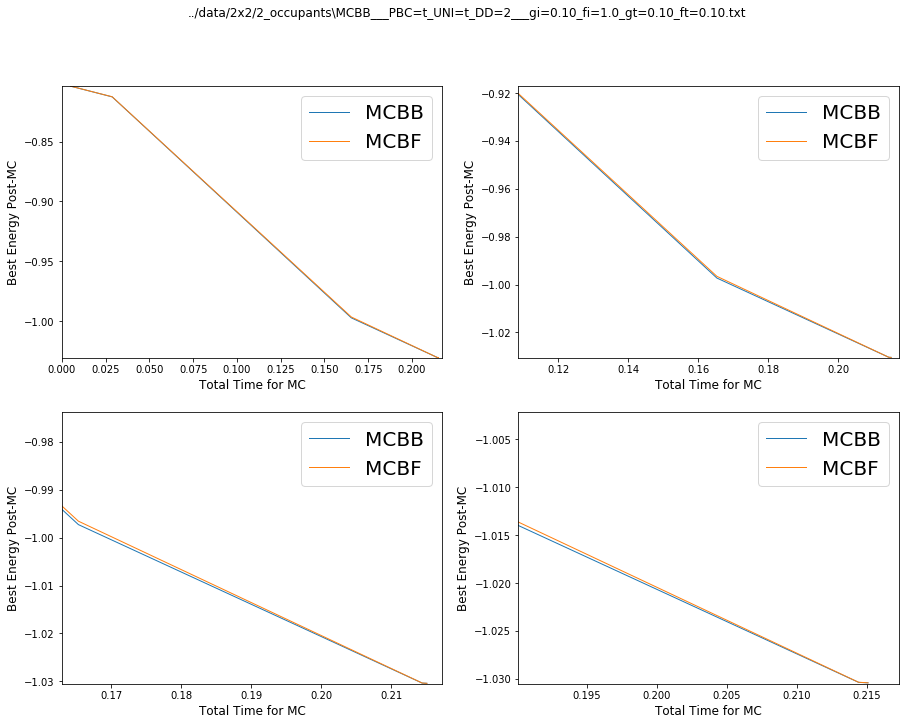

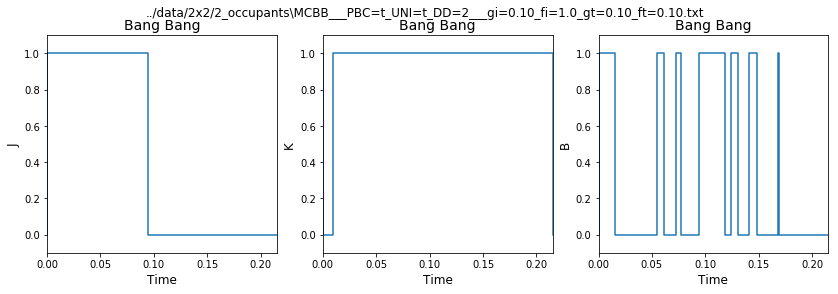

[[0.0, 0.0027617], [0.0, 0.0158521], [0.0, 0.0803188], [0.0, 0.0944608], [0.0, 0.0929543, 0.0952093, 0.0966352], [0.0, 0.0945152], [0.0, 0.0945573]]
[[0.        0.0027617]
 [0.        0.0158521]]


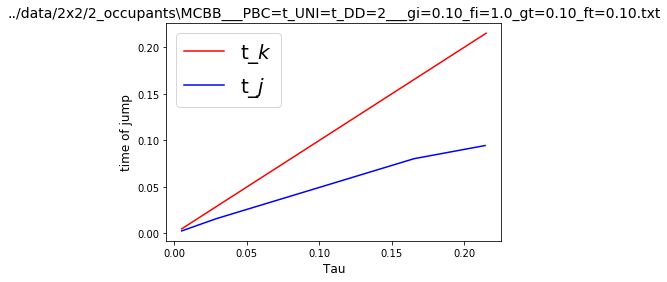

In [79]:
data_mcbb_whole, data_mcbf_whole, data_adia_whole = get_all_data()
#print(len(data_mcbb_whole[0]))
analyze_all_data(data_mcbb_whole, data_mcbf_whole, data_adia_whole)
plot_data(data_mcbb_whole,data_mcbf_whole,data_adia_whole)

#plots that we're interested in:
 # A single plot of j tv t and k vs t
    # E vs Tau
    # tj vs tau and tk vs tau
    


# Temporary Stuff

In [222]:

#print("k_jumps:", get_values(data_mcbb_whole[1][n],"k_jumps")[min_time_index_mcbb])
#print("k_jumps_vs_tau:", get_values(data_mcbb_whole[1][n],"k_jumps_vs_tau")[min_time_index_mcbb])
#print("k_jumps_vs_tau_ext:", get_values(data_mcbb_whole[1][n],"k_jumps_vs_tau_ext")[min_time_index_mcbb])

for x in range(len(data_mcbb_whole[1])):
    min_tau_mcbb, min_seed_mcbb, min_time_index_mcbb = get_optimal_tau_seed_index(data_mcbb_whole[1][x])

    print("\n\nk_jumps_vs_tau:", get_values(data_mcbb_whole[1][x],"k_jumps_vs_tau")[min_time_index_mcbb])
    print("k_jumps_vs_tau_ext:", get_values(data_mcbb_whole[1][x],"k_jumps_vs_tau_ext")[min_time_index_mcbb])
    print("k_jumps:", get_values(data_mcbb_whole[1][x],"k_jumps")[min_time_index_mcbb])



k_jumps_vs_tau: []
k_jumps_vs_tau_ext: []
k_jumps: []


k_jumps_vs_tau: [[0.0, 0.8948360000000001], [0.0, 0.8964591304347825], [0.0, 0.9061840266645697], [0.0, 0.9079910034711433], [0.0, 0.9198259059320564], [0.0, 0.9113198794965771]]
k_jumps_vs_tau_ext: [0.0, 0.9138986162789352]
k_jumps: [1, 1, 1, 1, 1, 1]


k_jumps_vs_tau: [[0.0, 0.942576], [0.0, 0.9443234782608696], [0.0, 0.9522300121587535], [0.0, 0.9533280470171184], [0.0, 0.9431463994109011], [0.0, 0.9579671485435054], [0.0, 0.9579718981237703], [0.0, 0.9579720583210984]]
k_jumps_vs_tau_ext: [0.0, 0.9541336545526139]
k_jumps: [1, 1, 1, 1, 1, 1, 1, 1]


k_jumps_vs_tau: [[0.502366, 1.0], [0.5039617391304347, 1.0], [0.5137965932607244, 1.0], [0.5253727929741102, 1.0], [0.5322108444300535, 1.0], [0.5353910331234811, 1.0], [0.5385643764165295, 1.0], [0.5412755317779862, 1.0], [0.5416035975404571, 1.0]]
k_jumps_vs_tau_ext: [0.5401447765915898, 1.0]
k_jumps: [1, 1, 1, 1, 1, 1, 1, 1, 1]


k_jumps_vs_tau: [[0.42772799999999994, 1.0], [0

# Label Reminders

In [11]:
print("The name of each file:\n", data_mcbb_whole[0])

n = 7
print("\n\nThe parameters for the nth file:\n", data_mcbb_whole[1][n][0])

string = 'j_protocols'
seed = 4
print("\n\nThe string for the nth file, accessing the seed-th seed:\n", get_values(data_mcbb_whole[1][n], string)[seed])
print("\n\n\n\n")

The name of each file:
 ['../data/2x2/2_occupants\\MCBB___PBC=t_UNI=t_DD=2___gi=0.10_fi=0.10_gt=0.10_ft=0.10.txt', '../data/2x2/2_occupants\\MCBB___PBC=t_UNI=t_DD=2___gi=0.10_fi=0.10_gt=0.10_ft=0.50.txt', '../data/2x2/2_occupants\\MCBB___PBC=t_UNI=t_DD=2___gi=0.10_fi=0.10_gt=0.10_ft=1.0.txt', '../data/2x2/2_occupants\\MCBB___PBC=t_UNI=t_DD=2___gi=0.10_fi=0.10_gt=0.50_ft=0.10.txt', '../data/2x2/2_occupants\\MCBB___PBC=t_UNI=t_DD=2___gi=0.10_fi=0.10_gt=0.50_ft=0.50.txt', '../data/2x2/2_occupants\\MCBB___PBC=t_UNI=t_DD=2___gi=0.10_fi=0.10_gt=0.50_ft=1.0.txt', '../data/2x2/2_occupants\\MCBB___PBC=t_UNI=t_DD=2___gi=0.10_fi=0.10_gt=1.0_ft=0.10.txt', '../data/2x2/2_occupants\\MCBB___PBC=t_UNI=t_DD=2___gi=0.10_fi=0.10_gt=1.0_ft=0.50.txt', '../data/2x2/2_occupants\\MCBB___PBC=t_UNI=t_DD=2___gi=0.10_fi=0.10_gt=1.0_ft=1.0.txt', '../data/2x2/2_occupants\\MCBB___PBC=t_UNI=t_DD=2___gi=0.10_fi=1.0_gt=0.10_ft=0.10.txt', '../data/2x2/2_occupants\\MCBB___PBC=t_UNI=t_DD=2___gi=0.10_fi=1.0_gt=0.10_ft=0.50